<a href="https://colab.research.google.com/github/mariusbiteau/Ecommerce-Customer-Segmentation/blob/main/Segmentation_Ecommerce_Customer_Segmentation_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Customer Segmentation for a Brazilian marketplace (Olist)

Olist would like you to provide its e-commerce teams with a customer segmentation that they can use on a daily basis for their communication campaigns.

### About the Dataset

The dataset includes 100k orders from 2016 to 2018 with several brands in Brazil. The data includes the following information: price, valuation, number of items, weight, description, geolocation...

### Project Goal

Help Olist teams understand the different types of users.
I will use unsupervised methods to group together clients with similar profiles. These categories can be used by the marketing team to better communicate.

For reasons of confidentiality, Olist does not provide a lot of data, so it is up to you to dig into the data you have and create the best features to exploit them.

Finally, your client, Olist, has specified his request as follows:

- The proposed segmentation must be exploitable and easy to use for the marketing team.
- You will evaluate how often the segmentation needs to be updated, in order to be able to quote for a maintenance contract.
- The code provided must comply with the PEP8 convention in order to be usable by Olist.


In [127]:
# Essentials / Data Handling
from google.colab import drive
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import json
import time
import six
import datetime as dt

# Plots
import seaborn as sns
import folium
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import LinearSegmentedColormap
pd.options.display.max_columns = None
plt.style.use('ggplot')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Stats
import math
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score

## 1. Data Import

In [2]:
drive.mount('/content/drive', force_remount=True)
csv_olist = '/content/drive/My Drive/OC_DataScientist/P5/df_olist_modelization.csv'
df = pd.read_csv(csv_olist)

Mounted at /content/drive


## 2. Data Description

In [ ]:
df.head(3)

,Unnamed: 0,order_id,order_status,order_purchase_timestamp,delay_delivery,period,customer_unique_id,n_item,product_category_name_english,product_photos_qty,product_description_lenght,order_amount,freight_amount,n_payment,prefered_payment,n_payment_type,total_paid,review_score,delivery_respect,order_purchase_month,cohort_month,cohort_index,ratio_freight_amount
0,0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7 days 02:34:47,2017-Q4,7c396fd4830fd04220f754e42b4e5bff,1.0,housewares,4.0,268.0,29.99,8.72,3.0,voucher,2.0,38.71,4,2,2017-10-01 00:00:00,2017-09-01 00:00:00,2,0.23
1,1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,5 days 08:32:15,2018-Q3,af07308b275d755c9edb36a90c618231,1.0,perfumery,1.0,178.0,118.70,22.76,1.0,boleto,1.0,141.46,4,2,2018-07-01 00:00:00,2018-07-01 00:00:00,1,0.16
2,2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,17 days 05:53:31,2018-Q3,3a653a41f6f9fc3d2a113cf8398680e8,1.0,auto,1.0,232.0,159.90,19.22,1.0,credit_card,1.0,179.12,5,2,2018-08-01 00:00:00,2018-08-01 00:00:00,1,0.11


##### Show data info


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98354 entries, 0 to 98353
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     98354 non-null  int64  
 1   order_id                       98354 non-null  object 
 2   order_status                   98354 non-null  object 
 3   order_purchase_timestamp       98354 non-null  object 
 4   delay_delivery                 96204 non-null  object 
 5   period                         98354 non-null  object 
 6   customer_unique_id             98354 non-null  object 
 7   n_item                         98354 non-null  float64
 8   product_category_name_english  98354 non-null  object 
 9   product_photos_qty             98354 non-null  float64
 10  product_description_lenght     98354 non-null  float64
 11  order_amount                   98354 non-null  float64
 12  freight_amount                 98354 non-null 

##### Fix data types


In [3]:
df['order_purchase_timestamp'] = \
    pd.to_datetime(df['order_purchase_timestamp'],
                   format="%Y-%m-%d %H:%M:%S")

Now, let's check our new data types and column names:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98354 entries, 0 to 98353
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     98354 non-null  int64         
 1   order_id                       98354 non-null  object        
 2   order_status                   98354 non-null  object        
 3   order_purchase_timestamp       98354 non-null  datetime64[ns]
 4   delay_delivery                 96204 non-null  object        
 5   customer_unique_id             98354 non-null  object        
 6   n_item                         98354 non-null  float64       
 7   product_category_name_english  98354 non-null  object        
 8   product_photos_qty             98354 non-null  float64       
 9   product_description_lenght     98354 non-null  float64       
 10  order_amount                   98354 non-null  float64       
 11  freight_amount 

##### Show statistical analysis of our data set
Let's show min, max, mean, std, and count of each column in the dataset.

In [ ]:
df.describe()

,Unnamed: 0,n_item,product_photos_qty,product_description_lenght,order_amount,freight_amount,n_payment,n_payment_type,total_paid,review_score,delivery_respect,cohort_index,ratio_freight_amount
count,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000,98354.000000
mean,49715.180460,1.141591,2.216392,782.432052,137.684871,22.820752,1.044462,1.022592,160.534034,4.090784,1.876741,1.094373,0.208785
std,28704.079645,0.538099,1.752826,656.244139,210.683379,21.656041,0.379175,0.148599,220.521254,1.342569,0.389599,0.849880,0.125751
min,0.000000,1.000000,0.000000,0.000000,0.850000,0.000000,1.000000,1.000000,9.590000,1.000000,0.000000,1.000000,0.000000
25%,24863.250000,1.000000,1.000000,341.000000,45.900000,13.850000,1.000000,1.000000,61.990000,4.000000,2.000000,1.000000,0.120000
50%,49714.500000,1.000000,1.000000,600.000000,86.900000,17.170000,1.000000,1.000000,105.280000,5.000000,2.000000,1.000000,0.180000
75%,74574.750000,1.000000,3.000000,987.000000,149.900000,24.030000,1.000000,1.000000,176.830000,5.000000,2.000000,1.000000,0.280000
max,99440.000000,21.000000,20.000000,3992.000000,13440.000000,1794.960000,29.000000,2.000000,13664.080000,5.000000,2.000000,20.000000,0.960000


## 2. RFM

#### 2.1 Setup

The target to be segmented being the customers, it is necessary to group the orders by customers.

To build the RFM metrics and have something consistent, I place myself as if the data were recent, at the beginning of Q4 2018.

In [5]:
df.order_purchase_timestamp.max()


Timestamp('2018-09-03 09:06:57')

In [6]:
date = df.order_purchase_timestamp.max() + dt.timedelta(days=2)
snapshot_date = date.replace(hour=0, minute=0, second=0)
snapshot_date

Timestamp('2018-09-05 00:00:00')

- For the Recency metric, I calculate the difference between the snapshot date and the most recent order date, in number of days.
- For the Frequency metric, I count the number of orders.
- For the MonetaryValue metric, I take into account the value of the product, without shipping costs. If a customer to purchase multiple products, whether in the same order or multiple orders, I sum the values of the products

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98354 entries, 0 to 98353
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Unnamed: 0                     98354 non-null  int64         
 1   order_id                       98354 non-null  object        
 2   order_status                   98354 non-null  object        
 3   order_purchase_timestamp       98354 non-null  datetime64[ns]
 4   delay_delivery                 96204 non-null  object        
 5   customer_unique_id             98354 non-null  object        
 6   n_item                         98354 non-null  float64       
 7   product_category_name_english  98354 non-null  object        
 8   product_photos_qty             98354 non-null  float64       
 9   product_description_lenght     98354 non-null  float64       
 10  order_amount                   98354 non-null  float64       
 11  freight_amount 

In [83]:
aggdict = {'order_id': 'count',
           'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
           'delivery_respect': lambda x: x.value_counts().index[0],
           'n_item': lambda x: x.value_counts().index[0],
           'product_category_name_english': lambda x: x.value_counts().index[0],
           'product_photos_qty': lambda x: x.value_counts().index[0],
           'product_description_lenght': lambda x: x.value_counts().index[0],
           'ratio_freight_amount': 'mean',
           'prefered_payment': lambda x: x.value_counts().index[0],
           'total_paid': 'sum',
           'review_score': lambda x: x.value_counts().index[0]}


customer = df.groupby('customer_unique_id').agg(aggdict)

columns_rename = {'order_purchase_timestamp': 'recency',
                  'order_id': 'frequency',
                  'total_paid': 'monetary_value'}

customer.rename(columns=columns_rename, inplace=True)

customer

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,health_beauty,1.0,534.0,0.24,credit_card,2067.42,5
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,baby,2.0,506.0,0.23,credit_card,84.58,4
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,auto,5.0,716.0,0.20,credit_card,112.46,5


In [9]:
print("The number of customers to have order more than one time is : {:.2f} %"
      .format(100*sum(customer["frequency"] > 1)/len(customer)))

The number of customers to have order more than one time is : 3.05 %


In [176]:
customer_RFM = customer.copy()

#### 2.2 Segmentation

In [177]:
#Segment Construction
# I define R and M based on the 4 quantiles
# I define F based on the number of times a customer ordered
# I grouped customer that ordered 4 times and more
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(customer_RFM['recency'], 4, labels=r_labels)
m_quartiles = pd.qcut(customer_RFM['monetary_value'], 4, labels=m_labels)

customer_RFM = customer_RFM.assign(R=r_quartiles.values)

customer_RFM['F'] = customer_RFM.frequency
customer_RFM['F'][customer_RFM.frequency > 3] = 4

customer_RFM = customer_RFM.assign(M=m_quartiles.values)

customer_RFM

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M
customer_unique_id,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5,4,1,3
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4,4,1,1
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3,1,1,2
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4,2,1,1
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,health_beauty,1.0,534.0,0.24,credit_card,2067.42,5,1,1,4
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,baby,2.0,506.0,0.23,credit_card,84.58,4,2,1,2
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,auto,5.0,716.0,0.20,credit_card,112.46,5,1,1,3


In [178]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

In [179]:
customer_RFM['RFM_Segment'] = customer_RFM.apply(join_rfm, axis=1)
customer_RFM['RFM_Score'] = customer_RFM[['R', 'F', 'M']].sum(axis=1)
customer_RFM

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5,4,1,3,413,8
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4,4,1,1,411,6
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3,1,1,2,112,4
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4,2,1,1,211,4
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5,2,1,4,214,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,453,2,2.0,health_beauty,1.0,534.0,0.24,credit_card,2067.42,5,1,1,4,114,6
fffea47cd6d3cc0a88bd621562a9d061,1,268,2,1.0,baby,2.0,506.0,0.23,credit_card,84.58,4,2,1,2,212,5
ffff371b4d645b6ecea244b27531430a,1,574,2,1.0,auto,5.0,716.0,0.20,credit_card,112.46,5,1,1,3,113,5


#### 2.3 Analysis 1

In [14]:
# 10 most populated segements are 
customer_RFM.groupby('RFM_Segment').size().\
    sort_values(ascending=False).head(10)

RFM_Segment
112    6120
111    6064
212    5976
311    5973
413    5949
313    5931
411    5905
211    5805
312    5718
213    5711
dtype: int64

In [173]:
# Segements Value
agg_dict = {'recency': 'mean',
            'frequency': 'mean',
            'monetary_value': 'mean',
            'customer_unique_id': 'count'}

score_RFM = customer_RFM.reset_index().groupby('RFM_Score')\
                        .agg(agg_dict).round(1)

In [174]:
score_RFM

,recency,frequency,monetary_value,customer_unique_id
RFM_Score,,,,
3,458.1,1.0,43.7,6064
4,368.9,1.0,64.2,11938
5,301.0,1.0,87.6,17489
6,241.1,1.0,163.6,23030
7,177.5,1.0,203.3,17574
8,122.9,1.1,258.9,12168
9,74.0,1.1,394.9,6253
10,75.6,2.1,397.6,517
11,87.7,3.5,569.3,65


#### 2.3 Analysis 2

Each customer is characterized according to the score for each variable R, F M which characterizes it

9 segments are defined :

- Champions: recent purchases, buys often and spends a lot
- Loyal Customers: buy regularly, sensitive to promotions
- Potential Loyalist: new customers with average purchase frequency
- Recent Customers: recent but infrequent purchases
- Promising: new buyers, but low spenders
- Need Attention: medium spending, medium frequency, medium recent purchase
- About to Sleep : customers who tend to disappear
- Can't Lose Them: buy regularly, need to get them back
- At Risk: Spent a lot, bought often but long ago
- Lost: low spend, low attendance, bought a while ago
- Others: not categorizable

In [17]:
categories_1 = ["Champions",
                "Loyal Customers",
                "Potential Loyalist",
                "Recent Customers",
                "Promising",
                "Need Attention",
                "About to Sleep",
                "Can't Lose Them",
                "At Risk",
                "Lost",
                "Others"]

In [18]:
def calculate_segments(customer_RFM):
    """
    Return the the customer associated segement based on the score of the features R, F et M

    Parameters
    rfm(pd.DataFrame): Must have R,F and M features

    Return:
    str: Segment Name
    """

    if 4 <= customer_RFM["R"] <= 5 and 4 <= customer_RFM["F"] <= 5 and 4 <= customer_RFM["M"] <= 5:
        return "Champions"

    elif 3 <= customer_RFM["R"] <= 5 and 3 <= customer_RFM["F"] <= 5 and 2 <= customer_RFM["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= customer_RFM["R"] <= 5 and 1 <= customer_RFM["F"] <= 3 and 1 <= customer_RFM["M"] <= 3:
        return "Potential Loyalist"

    elif customer_RFM["R"] >= 4 and customer_RFM["F"] <= 2:
        return "Recent Customers"

    elif 3 <= customer_RFM["R"] <= 4 and customer_RFM["F"] <= 1 and customer_RFM["M"] <= 1:
        return "Promising"

    elif 2 <= customer_RFM["R"] <= 3 and 2 <= customer_RFM["F"] <= 3 and 2 <= customer_RFM["M"] <= 3:
        return "Need Attention"

    elif 2 <= customer_RFM["R"] <= 3 and customer_RFM["F"] <= 2 and customer_RFM["M"] <= 2:
        return "About to Sleep"

    elif customer_RFM["R"] <= 1 and 4 <= customer_RFM["F"] <= 5 and 4 <= customer_RFM["M"] <= 5:
        return "Can't Lose Them"

    elif customer_RFM["R"] <= 2 and 2 <= customer_RFM["F"] <= 5 and 2 <= customer_RFM["M"] <= 5:
        return "At Risk"

    elif customer_RFM["R"] <= 2 and customer_RFM["F"] <= 2 and customer_RFM["M"] <= 2:
        return "Lost"

    else:
        return "Others"


In [19]:
# RFM Score
customer_RFM["RFM Score"] = customer_RFM.apply(calculate_segments, axis=1)

In [82]:
# Dsiplay the five first rows
customer_RFM.head()

,frequency,recency,delivery_respect,n_item,product_category_name_english,product_photos_qty,product_description_lenght,ratio_freight_amount,prefered_payment,monetary_value,review_score,R,F,M,RFM_Segment,RFM_Score,RFM Score
customer_unique_id,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,117,2,1.0,bed_bath_table,1.0,236.0,0.08,credit_card,141.90,5,4,1,3,413,8,Potential Loyalist
0000b849f77a49e4a4ce2b2a4ca5be3f,1,120,2,1.0,health_beauty,1.0,635.0,0.30,credit_card,27.19,4,4,1,1,411,6,Potential Loyalist
0000f46a3911fa3c0805444483337064,1,543,2,1.0,stationery,3.0,177.0,0.20,credit_card,86.22,3,1,1,2,112,4,Lost
0000f6ccb0745a6a4b88665a16c9f078,1,327,2,1.0,telephony,5.0,1741.0,0.40,credit_card,43.62,4,2,1,1,211,4,About to Sleep
0004aac84e0df4da2b147fca70cf8255,1,294,2,1.0,telephony,3.0,794.0,0.09,credit_card,196.89,5,2,1,4,214,7,Others


## 3. K-Means segmentation

During the EDA, I found that the customers didn't come back to Olist. I will focus my segmentation based on customer satisfaction and RFM metrics.

In [180]:
col_list = ['recency',
            'frequency',
            'monetary_value',
            'review_score',
            'delivery_respect']

customer_km = customer[col_list].copy()

customer_km.head()

,recency,frequency,monetary_value,review_score,delivery_respect
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,5,2
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,4,2
0000f46a3911fa3c0805444483337064,543,1,86.22,3,2
0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,4,2
0004aac84e0df4da2b147fca70cf8255,294,1,196.89,5,2


### 3.1 Manage skewness and scale each variable

The data should meet assumptions where the variables are not skewed and have the same mean and variance.

Because of that, we have to manage the skewness of the variables.
Here are the visualizations of each variable

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

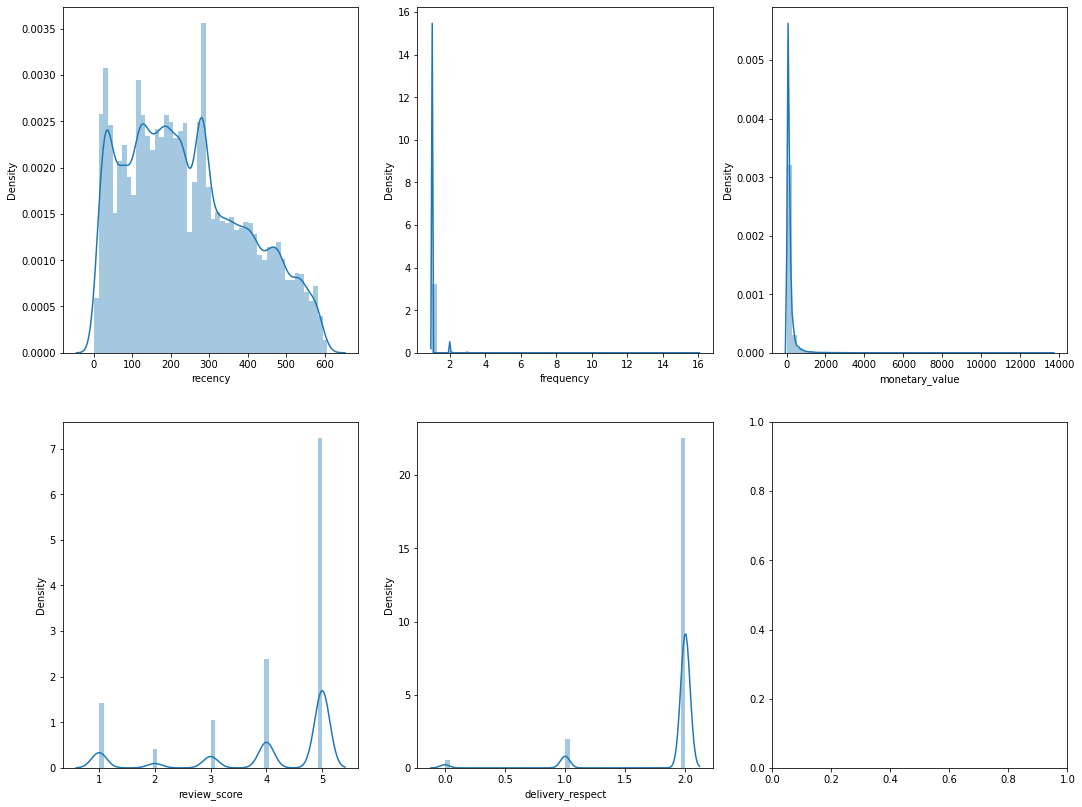

In [85]:
def plot_multiple_histograms(df, cols):
    matplotlib.rcParams['figure.figsize'] = (18,14)
    num_plots = len(cols)
    num_cols = math.ceil(np.sqrt(num_plots))
    num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
            
        if num_rows == 1:
            if num_cols == 1:
                sns.distplot(df[col], kde=True, ax=axs)
            else:
                sns.distplot(df[col], kde=True, ax=axs[j])
        else:
            sns.distplot(df[col], kde=True, ax=axs[i, j])

            
plot_multiple_histograms(customer_km, ["recency","frequency", "monetary_value", "review_score", "delivery_respect"])


matplotlib.rcParams["figure.figsize"] = [6.4, 4.8]

As we can see from above, we have to transform the data, so it has a more symmetrical form.

There are some methods that we can use to manage the skewness, they are,
- log transformation
- square root transformation
- box-cox transformation

Note: We can use the transformation if and only if the variable only has positive values.

In [86]:
customer_km.describe()

,recency,frequency,monetary_value,review_score,delivery_respect
count,95121.000000,95121.000000,95121.000000,95121.000000,95121.000000
mean,243.076671,1.033988,165.990311,4.087341,1.878975
std,151.274876,0.211206,228.382838,1.344452,0.385949
min,1.000000,1.000000,9.590000,1.000000,0.000000
25%,120.000000,1.000000,63.100000,4.000000,2.000000
50%,225.000000,1.000000,107.920000,5.000000,2.000000
75%,352.000000,1.000000,183.120000,5.000000,2.000000
max,607.000000,16.000000,13664.080000,5.000000,2.000000


In [181]:
customer_km.var().sort_values(ascending=False)

monetary_value      52158.720613
recency             22884.088140
review_score            1.807552
delivery_respect        0.148957
frequency               0.044608
dtype: float64

In [182]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customer_km[x], ax=ax[0,0])
    sns.distplot(np.log(customer_km[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customer_km[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customer_km[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customer_km[x].skew().round(2))
    print(np.log(customer_km[x]).skew().round(2))
    print(np.sqrt(customer_km[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customer_km[x])[0]).skew().round(2))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

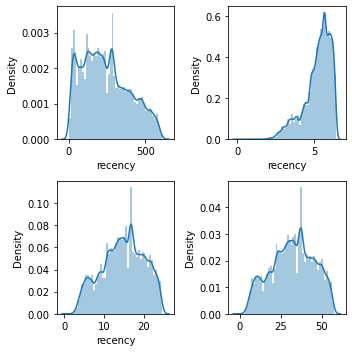

0.41
-1.07
-0.21
-0.15


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

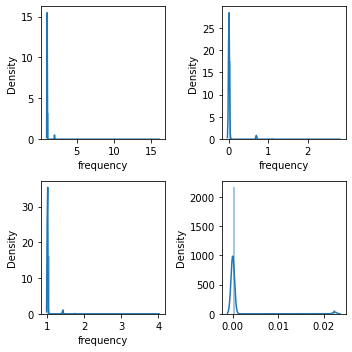

11.46
6.04
7.03
5.46


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

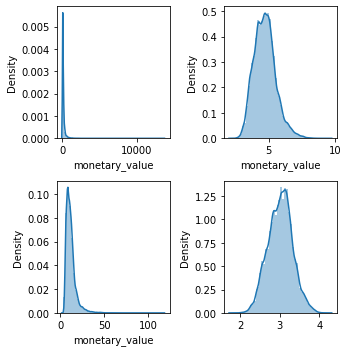

9.1
0.51
2.52
0.01


In [89]:
analyze_skewness('recency')
analyze_skewness('frequency')
analyze_skewness('monetary_value')

In [183]:
boxcox_customer_km = customer_km.copy()

list = ['recency', 'frequency', 'monetary_value']
for i in list:
    boxcox_customer_km[i + '_boxcox'] = stats.boxcox(customer_km[i])[0]
    boxcox_customer_km.drop(i, axis=1, inplace=True)

boxcox_customer_km.head(5)

,review_score,delivery_respect,recency_boxcox,frequency_boxcox,monetary_value_boxcox
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,5,2,22.463328,0.0,3.126459
0000b849f77a49e4a4ce2b2a4ca5be3f,4,2,22.798670,0.0,2.407633
0000f46a3911fa3c0805444483337064,3,2,53.936142,0.0,2.934449
0000f6ccb0745a6a4b88665a16c9f078,4,2,40.548827,0.0,2.638391
0004aac84e0df4da2b147fca70cf8255,5,2,38.177292,0.0,3.242521


#### Scaling Variables

If we look at the plot once more, each variable don’t have the same mean and variance. We have to normalize it.

In [184]:
scaler = StandardScaler()
std_customer_km = scaler.fit_transform(boxcox_customer_km)

std_customer_km = pd.DataFrame(std_customer_km,
                               index=boxcox_customer_km.index,
                               columns=boxcox_customer_km.columns)
std_customer_km

,review_score,delivery_respect,recency_boxcox,frequency_boxcox,monetary_value_boxcox
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.678837,0.313579,-0.749988,-0.177362,0.369686
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.064965,0.313579,-0.724156,-0.177362,-1.964874
0000f46a3911fa3c0805444483337064,-0.808766,0.313579,1.674430,-0.177362,-0.253911
0000f6ccb0745a6a4b88665a16c9f078,-0.064965,0.313579,0.643177,-0.177362,-1.215432
0004aac84e0df4da2b147fca70cf8255,0.678837,0.313579,0.460492,-0.177362,0.746627
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.678837,0.313579,1.273067,-0.177362,2.828561
fffea47cd6d3cc0a88bd621562a9d061,-0.064965,0.313579,0.309823,-0.177362,-0.279232
ffff371b4d645b6ecea244b27531430a,0.678837,0.313579,1.805482,-0.177362,0.086473


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

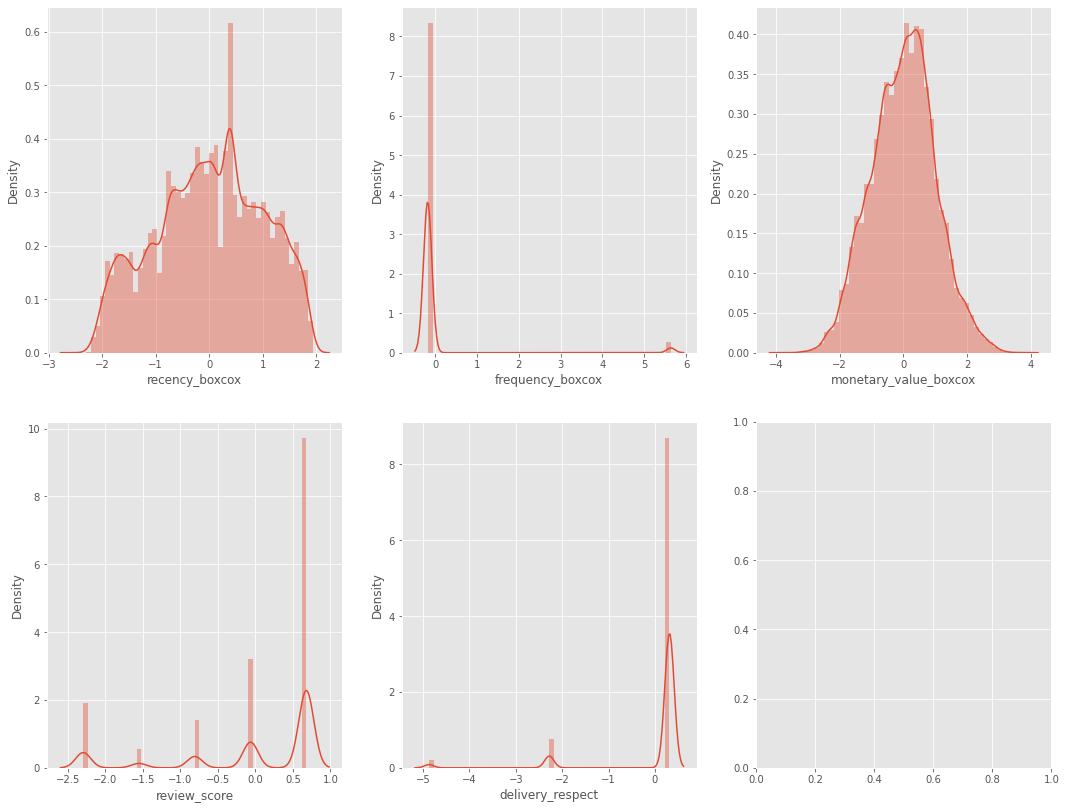

In [185]:
plot_multiple_histograms(std_customer_km, ["recency_boxcox","frequency_boxcox", "monetary_value_boxcox", 'review_score', 'delivery_respect'])

### 3.2. Clusters Definition

To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data.

2 methods exist to define the number of clusters:

- Visual method with Elbow criterion
- Mathematical method with silhouette

Text(0.5, 1.0, 'Elbow Method For Optimal k')

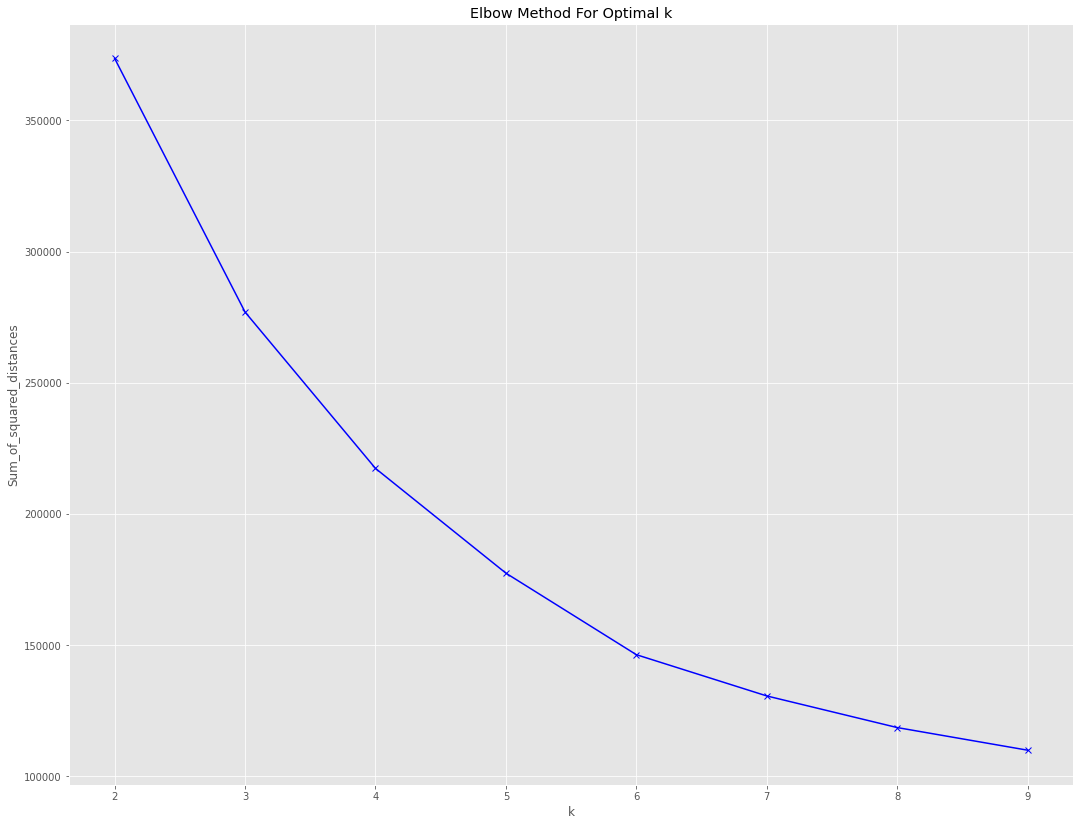

In [186]:
# Elbow
Sum_of_squared_distances = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(std_customer_km)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')


In [ ]:
# Silhouette
silhouette = []
K = range(2, 10)
for k in K:
    print(f'Nb of cluster in process :  {k}')
    km = KMeans(n_clusters=k)
    km = km.fit(std_customer_km)
    score = round(silhouette_score(std_customer_km, km.labels_), 2)
    silhouette.append(score)

silh_dict = {'Number of cluster': K,
             'Silhouette Score': silhouette}
silhouette_df = pd.DataFrame(data=silh_dict)
silhouette_df

Nb of cluster in process :  2
Nb of cluster in process :  3
Nb of cluster in process :  4
Nb of cluster in process :  5
Nb of cluster in process :  6
Nb of cluster in process :  7
Nb of cluster in process :  8
Nb of cluster in process :  9


,Number of cluster,Silhouette Score
0,2,0.45
1,3,0.44
2,4,0.32
3,5,0.29
4,6,0.32
5,7,0.29
6,8,0.30
7,9,0.29


We will take the best parameter by looking at where the k-value will have a linear trend on the next consecutive k.
Based on our observation, the k-value of 6 is the best hyperparameter

In [211]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(std_customer_km)
cluster_labels = kmeans.labels_
customer_km = customer_km.assign(cluster = cluster_labels)

### 3.3 Evaluating Clusters

In [ ]:
print('kmeans: {}'.format(silhouette_score(std_customer_km, cluster_labels, metric='euclidean')))

### 3.4 Clusters Visualization

To visualize the clusters you can use one of the most popular methods for dimensionality reduction, namely PCA and t-SNE.

#### Functions

In [139]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks,
                             labels=None, alpha=1,
                             illustrative_var=None,
                             png_filename='projection'):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(7, 7))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1],
                                X_projected[selected, d2],
                                alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i],
                             fontsize='14', ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title(
                "Projection des individus (sur F{} et F{})".format(d1+1, d2+1))

            plt.savefig("{}_F{}_F{}.png".format(png_filename, d1+1, d2+1),
                        transparent=True)
            plt.close()
            display(Image("{}_F{}_F{}.png".format(png_filename, d1+1, d2+1)))
            # plt.show(block=False)

#### *Principal Component Analysis (PCA)*
PCA works by using orthogonal transformations to convert correlates features into a set of values of linearly uncorrelated features. What is left are features that contain the largest possible variance.

In [188]:
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

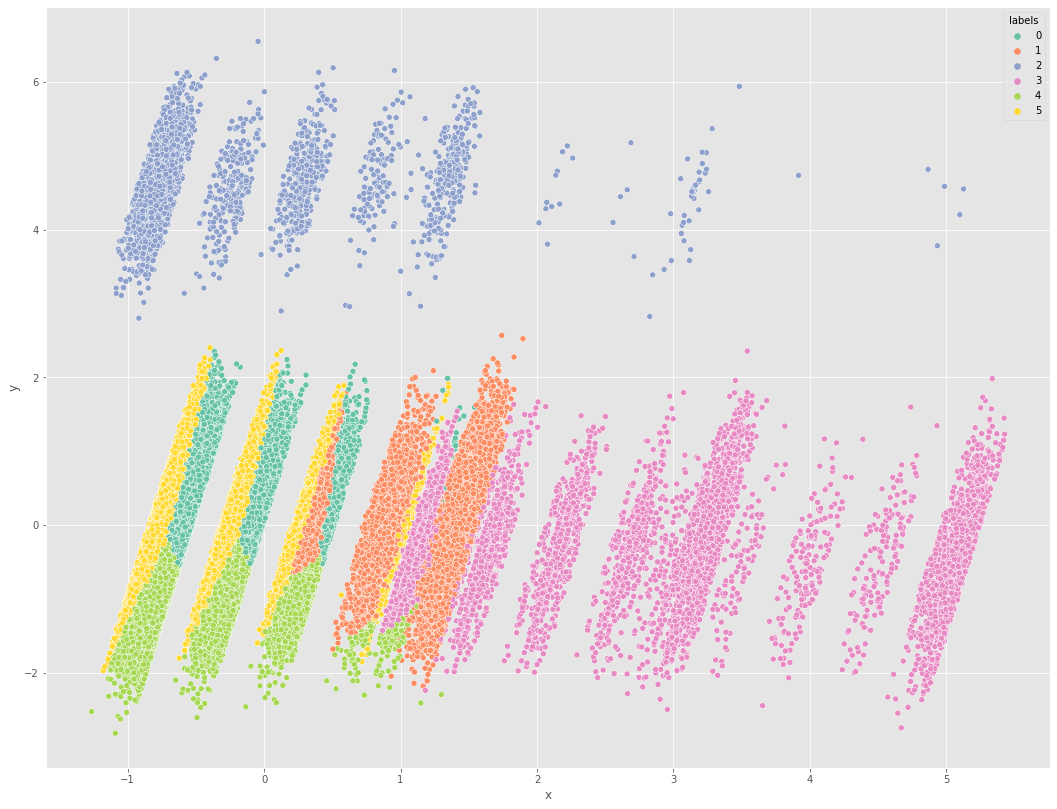

In [189]:
pca_df = prepare_pca(2, std_customer_km.drop(columns='cluster'), cluster_labels)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")

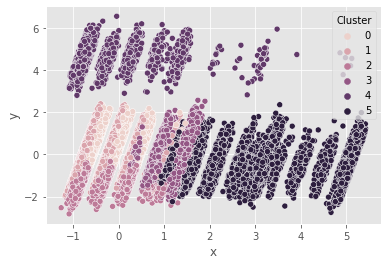

In [169]:
pca = PCA(n_components=2)
pca_array = pca.fit_transform(std_customer_km.drop(columns='cluster'))
pca_data = pd.DataFrame(pca_array, columns=['x', 'y'], index=std_customer_km.index)
pca_data['Cluster'] = std_customer_km.cluster
sns.scatterplot(x='x', y='y', hue='Cluster', data=pca_data)
fig.suptitle('PCA plot of clusters', fontsize=20)
plt.show()

#### *t-distributed Stochastic Neighbor Embedding (t-SNE)*
t-SNE is an algorithm for visualizing high dimensional data. It uses local relationships between points to create a low-dimensional mapping which results in capturing non-linear structures.

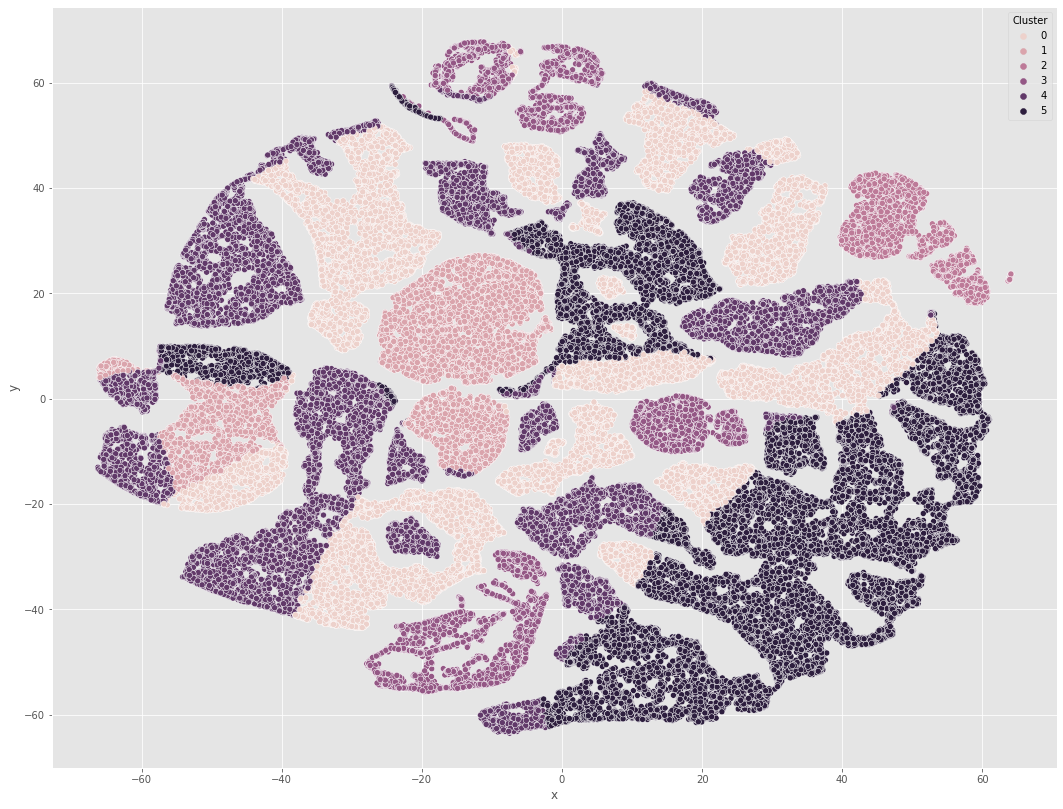

In [190]:
tsne = TSNE(learning_rate=300, perplexity=80, early_exaggeration=20)
tsne_array = tsne.fit_transform(std_customer_km.drop(columns='cluster'))
tsne_data = pd.DataFrame(tsne_array, columns=['x', 'y'], index=std_customer_km.index)
tsne_data['Cluster'] = std_customer_km.cluster
sns.scatterplot(x='x', y='y', hue='Cluster', data=tsne_data)

In [ ]:
tsne_3d_df = prepare_tsne(3, std_customer_km.drop(columns='cluster'), cluster_labels)

In [ ]:
plot_3d(tsne_3d_df)

In [ ]:
plot_animation(tsne_3d_df, 'kmeans', 'kmeans')

### 3.2. Centroids Analysis and Cluster Interpretation

In [203]:
# Centroids integration in a dataframe
ctds = pd.DataFrame(kmeans.cluster_centers_,
                    columns=std_customer_km.columns)
ctds = ctds.reset_index().rename(columns={'index': 'cluster_name'})
ctds

,recency,frequency,monetary_value,review_score,delivery_respect,Cluster,cluster
0,461.829477,1.022850,117.732226,4.154223,1.902780,1.836026,1.836026
1,91.399494,1.025005,112.719463,4.202666,1.898074,4.243343,4.243343
2,249.159817,1.134450,1029.351740,3.911213,1.857433,1.333333,1.333333
3,259.482756,1.021240,104.004120,3.991466,1.852817,2.245677,2.245677
4,235.540881,1.088050,2467.447862,3.745283,1.776730,1.377358,1.377358
5,223.121029,1.113970,418.087823,3.904475,1.855516,1.609928,1.609928


In [192]:
std_customer_km = pd.DataFrame(std_customer_km, columns=['review_score', 'delivery_respect', 'recency_boxcox', 'frequency_boxcox', 'monetary_value_boxcox'])
std_customer_km['Cluster'] = cluster_labels
std_customer_km.head(10)

,review_score,delivery_respect,recency_boxcox,frequency_boxcox,monetary_value_boxcox,Cluster
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.678837,0.313579,-0.749988,-0.177362,0.369686,5
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.064965,0.313579,-0.724156,-0.177362,-1.964874,4
0000f46a3911fa3c0805444483337064,-0.808766,0.313579,1.674430,-0.177362,-0.253911,0
0000f6ccb0745a6a4b88665a16c9f078,-0.064965,0.313579,0.643177,-0.177362,-1.215432,4
0004aac84e0df4da2b147fca70cf8255,0.678837,0.313579,0.460492,-0.177362,0.746627,0
0004bd2a26a76fe21f786e4fbd80607f,-0.064965,0.313579,-0.465094,-0.177362,0.560122,5
00050ab1314c0e55a6ca13cf7181fecf,-0.064965,0.313579,-0.583050,-0.177362,-1.538559,4
00053a61a98854899e70ed204dd4bafe,-2.296368,0.313579,-0.202095,-0.177362,1.526498,1
0005e1862207bf6ccc02e4228effd9a0,-0.064965,0.313579,1.700057,-0.177362,0.436290,0


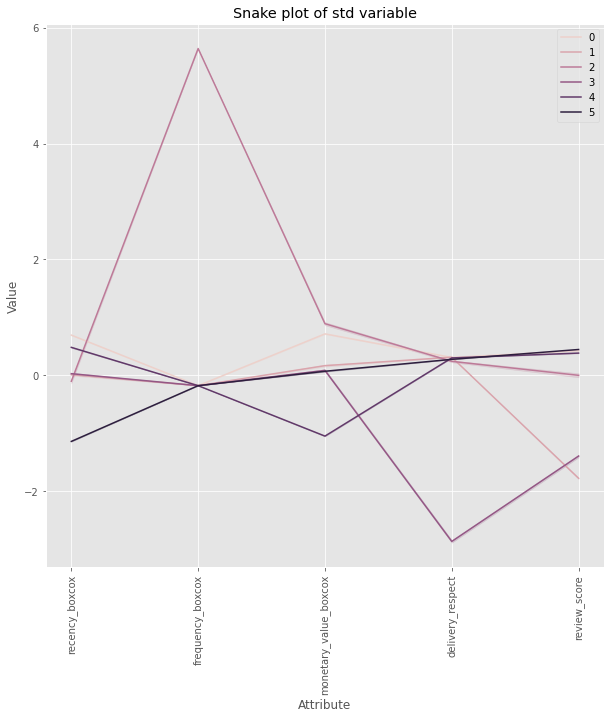

In [193]:
std_customer_melt = pd.melt(std_customer_km.reset_index(),
                            id_vars=['customer_unique_id', 'Cluster'],
                            value_vars=['recency_boxcox',
                                        'frequency_boxcox',
                                        'monetary_value_boxcox',
                                        'delivery_respect',
                                        'review_score'],
                            var_name='Attribute',
                            value_name='Value')

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot()
plt.title('Snake plot of std variable')
sns.lineplot(x='Attribute',
             y='Value',
             hue='Cluster',
             data=std_customer_melt)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1))

In [194]:
customer_km = pd.DataFrame(customer_km, columns=['recency', 'frequency', 'monetary_value','review_score', 'delivery_respect'])
customer_km['Cluster'] = cluster_labels
customer_km.head(10)

,recency,frequency,monetary_value,review_score,delivery_respect,Cluster
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,5,2,5
0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,4,2,4
0000f46a3911fa3c0805444483337064,543,1,86.22,3,2,0
0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,4,2,4
0004aac84e0df4da2b147fca70cf8255,294,1,196.89,5,2,0
0004bd2a26a76fe21f786e4fbd80607f,152,1,166.98,4,2,5
00050ab1314c0e55a6ca13cf7181fecf,137,1,35.38,4,2,4
00053a61a98854899e70ed204dd4bafe,188,1,419.18,1,2,1
0005e1862207bf6ccc02e4228effd9a0,549,1,150.12,4,2,0


<Figure size 1296x1008 with 0 Axes>

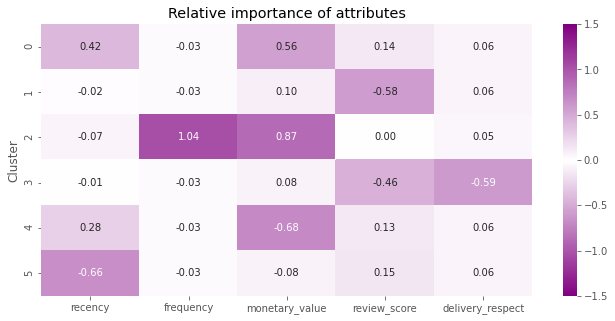

In [195]:
cluster_avg = customer_km.groupby('Cluster').mean()
population_avg = customer_km.drop(columns='Cluster').mean()

relative_imp = (cluster_avg / population_avg).round(2)
relative_imp = relative_imp - 1

plt.clf()
plt.figure(figsize=(11, 5))
plt.title('Relative importance of attributes')
cmap = LinearSegmentedColormap.from_list(name='test',
                                         colors=['purple', 'white', 'purple'])
sns.heatmap(data=relative_imp,
            annot=True,
            fmt='.2f',
            cmap=cmap,
            vmin=-1.5,
            vmax=1.5)

- Cluster 0 : Top Customer
- Cluster 1 : Unhappy customer
- Cluster 2 : Active customer
- Cluster 3 : Non delivered/late customer
- Cluster 4 : Low value customer
- Cluster 5 : Recent customer

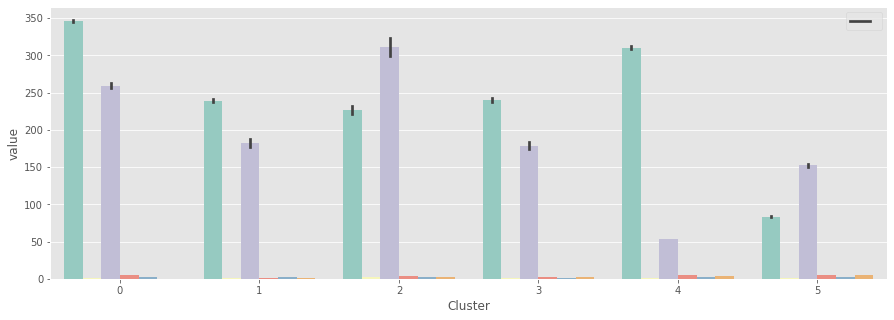

In [200]:
tidy = std_customer_km.melt(id_vars='Cluster')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Cluster', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])

### 3.5 Interpreting Clusters